# OCR machine learning

## Create train data

In [68]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from string import ascii_letters, digits, punctuation
from PIL import Image, ImageOps

!rm model_data -r
!rm png_data -r
!mkdir model_data
!mkdir png_data

height = 20
width = 12

font = {'family' : 'monospace'}

for symbol in ascii_letters+digits+punctuation+" ":
    
    # for storage compliance
    symbol_or_name = "dot" if symbol == "." else "slash" if symbol =="/" else symbol
    
    # one letter per image
    px = 1/plt.rcParams['figure.dpi']
    fig = plt.figure(figsize=(width*px, height*px))
    fig.set_dpi(300)
    fig.text(0, 1, symbol, font, va='top', ha='left', size=20)
    fig.savefig(f"png_data/{symbol_or_name}.png")
    plt.close(fig)
      
    # rotate images for more data
    img = Image.open(f"png_data/{symbol_or_name}.png")
    
    pixel_shift = 1
    crop_area = [[pixel_shift, 0, width, height],
                 [0, pixel_shift, width, height],
                 [0, 0, width-pixel_shift, height],
                 [0, 0, width, height-pixel_shift]]
    for i, shift in enumerate(crop_area):
        img_crop = img.crop(shift)
        img_crop = ImageOps.pad(img_crop, img.size, color='white', centering=(0,0))
        for rot in range(-10, 11):
            img_res = img_crop.rotate(rot, fillcolor='white')                
            img_res.save(f"model_data/{symbol_or_name}_{rot}_{i}.png")  

In [69]:
# !tar -xzf model_data.tgz
!ls -al model_data

total 31920
-rw-r--r--. 1 root root    119 Apr 11 09:16 ' _-10_0.png'
-rw-r--r--. 1 root root    122 Apr 11 09:16 ' _-10_1.png'
-rw-r--r--. 1 root root    119 Apr 11 09:16 ' _-10_2.png'
-rw-r--r--. 1 root root    122 Apr 11 09:16 ' _-10_3.png'
-rw-r--r--. 1 root root     89 Apr 11 09:16 ' _-1_0.png'
-rw-r--r--. 1 root root     91 Apr 11 09:16 ' _-1_1.png'
-rw-r--r--. 1 root root     89 Apr 11 09:16 ' _-1_2.png'
-rw-r--r--. 1 root root     91 Apr 11 09:16 ' _-1_3.png'
-rw-r--r--. 1 root root     89 Apr 11 09:16 ' _-2_0.png'
-rw-r--r--. 1 root root     91 Apr 11 09:16 ' _-2_1.png'
-rw-r--r--. 1 root root     89 Apr 11 09:16 ' _-2_2.png'
-rw-r--r--. 1 root root     91 Apr 11 09:16 ' _-2_3.png'
-rw-r--r--. 1 root root     91 Apr 11 09:16 ' _-3_0.png'
-rw-r--r--. 1 root root     91 Apr 11 09:16 ' _-3_1.png'
-rw-r--r--. 1 root root     91 Apr 11 09:16 ' _-3_2.png'
-rw-r--r--. 1 root root     91 Apr 11 09:16 ' _-3_3.png'
-rw-r--r--. 1 root root    105 Apr 11 09:16 ' _-4_0.png'
-rw-r--r--. 1 r

## Model

### Load data

In [70]:
import os
import re
import numpy as np
import matplotlib.image as mpimg
from pathlib import Path
# from keras.utils import to_categorical

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Path to the data directory
data_dir = Path("./model_data/")

# Get list of all the images
images_paths = sorted(list(map(str, list(data_dir.glob("*.png")))))

labels = [ord(re.split("_-?\d+_\d.png",image_path.split(os.path.sep)[-1])[0].replace('dot','.').replace('slash','/')) for image_path in images_paths]
images = [np.array(rgb2gray(mpimg.imread(image_path))) for image_path in images_paths]

def split_data(images, labels, train_size=0.70, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_test, y_test = images[indices[train_samples:]], labels[indices[train_samples:]]
#     y_train, y_test = np.reshape(y_train, (len(y_train), 1)), np.reshape(y_test, (len(y_test), 1))
    return x_train, x_test, y_train, y_test


# Splitting data into training and validation sets
x_train, x_test, y_train, y_test = split_data(np.array(images), np.array(labels))

# x_train, x_test = np.reshape(x_train, (1, x_train.shape[0], x_train.shape[1], x_train.shape[2])), np.reshape(x_test, (1, x_test.shape[0], x_test.shape[1], x_test.shape[2]))

print(f'Train: Images={x_train.shape}, Labels={y_train.shape}')
print(f'Valid: Images={x_test.shape}, Labels={y_test.shape}')

Train: Images=(5586, 20, 12), Labels=(5586,)
Valid: Images=(2394, 20, 12), Labels=(2394,)


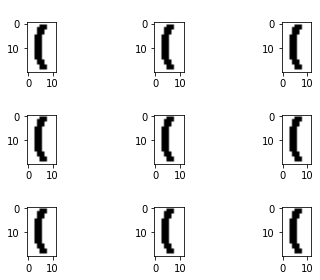

In [72]:
fig = plt.figure()
start = 50
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(np.array(rgb2gray(mpimg.imread("model_data/(_0_0.png"))), cmap=plt.get_cmap('gray'))
    plt.title(" ")
fig.tight_layout(h_pad=1)
plt.show()

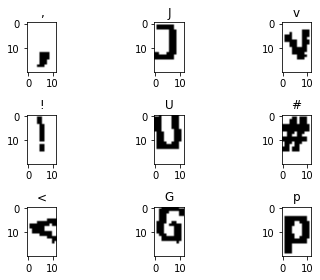

In [57]:
fig = plt.figure()
start = 50
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[start+i], cmap=plt.get_cmap('gray'))
    plt.title(chr(y_train[start+i]))
fig.tight_layout(h_pad=1)
plt.show()

### Build and train model 

In [85]:
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

height = 20
width = 12

model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(height, width, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(255, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
tstart = time()
h = model.fit(x_train, y_train, epochs=6, batch_size=8, validation_data=(x_test, y_test))
tstop = time()
# test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"time passed: {(int)(tstop-tstart)//3600}h {(int)(tstop-tstart)%3600//60}m {(int)(tstop-tstart)%60}s")



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 18, 10, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 3, 64)          18496     
                                                                 
 flatten_18 (Flatten)        (None, 1344)              0         
                                                                 
 dense_24 (Dense)            (None, 64)                86080     
                                                                 
 flatten_19 (Flatten)        (None, 64)                0         
                                                      

<AxesSubplot:>

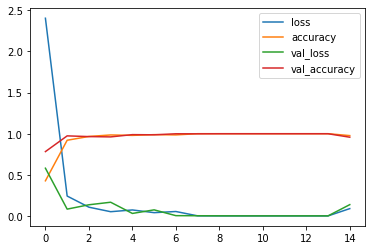

In [86]:
# !pip install pandas
import pandas as pd
pd.DataFrame(h.history).plot()

## Check predictions

In [59]:
# total = len(x_test)
# correct = 0
# preds = []
# for image, label in zip(x_test, y_test):
#     pred = model.predict(image.reshape(1, height, width, 1)).argmax()
#     preds.append(pred)
#     ok = True if pred == label else False
#     if ok:   
#         correct = correct + 1
#     else:
#          print(f"FALSE --- pred: {chr(pred)}, actual: {chr(label)}")
        
# fig = plt.figure()
# for i in range(20,29):
#     plt.subplot(330 + 1 + i)
#     plt.imshow(x_test[i], cmap=plt.get_cmap('gray'))
#     plt.title(chr(preds[i]))
# fig.tight_layout(h_pad=2)
# plt.show()
        
# print(f"acc: {correct/total * 100}%")


## Sample page

### Create page

In [74]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from textwrap import wrap
import numpy as np
%matplotlib inline

!rm sample_text.png

fig = plt.figure(figsize=(8.268, 11.693))
fig.set_dpi(300)
text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec molestie pulvinar felis, non porta lectus placerat eget. Pellentesque sagittis nunc aliquam nisi commodo mattis. Quisque mi neque, aliquet eu lorem ut, varius rutrum purus. Sed tristique ultrices cursus. Quisque vitae ante vitae odio volutpat iaculis. Pellentesque odio odio, pharetra sed maximus vel, pharetra id dolor. Pellentesque tempor elit ac massa facilisis pharetra." # Maecenas cursus, augue eget malesuada aliquam, quam augue mattis metus, non congue enim turpis in nulla. Nulla fringilla nibh vel sapien lacinia accumsan. Morbi bibendum arcu sed ligula vehicula, ut tincidunt turpis aliquam. Nam tincidunt porttitor turpis eu aliquam. Ut dui libero, vulputate eu hendrerit non, consectetur id justo. Morbi posuere fermentum leo eget lobortis. Donec scelerisque interdum ipsum, eget pretium arcu hendrerit non. Sed eu hendrerit augue. Morbi iaculis sollicitudin lorem et hendrerit. Fusce tincidunt ante ac massa euismod, id placerat nunc posuere. Etiam vestibulum, lectus in sollicitudin ornare, ex erat sagittis nulla, vel ultrices enim enim nec nisl. Vivamus eu accumsan nulla. Duis ac massa id dui malesuada tristique. Fusce blandit hendrerit interdum. In maximus nibh non nulla aliquam tempor. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Suspendisse interdum enim quam, et fringilla magna placerat dignissim. Cras lacus nunc, auctor at maximus sed, luctus eu turpis. Nam mi odio, lobortis eget lacus id, varius convallis metus.Nam eget laoreet libero, sit amet imperdiet nisl. Aliquam vitae semper sapien. Morbi eget ultricies velit. Aenean eleifend aliquam enim non tempus. Aenean pulvinar nibh sed volutpat sagittis. Cras congue lorem magna, id rutrum lacus condimentum eu. Aliquam at nunc non leo vestibulum pulvinar sed a purus. Nulla sit amet lacus id ante venenatis varius. Praesent accumsan ut magna lobortis volutpat. Quisque ac dui sed neque semper ornare ultricies sed metus. Maecenas eu nisl vitae neque convallis tempus et ac mauris. Donec gravida justo lacus, sit amet viverra risus dignissim ac. Nam nunc libero, molestie aliquam tellus eu, interdum viverra ante."
font = {'family' : 'monospace'}
ftxt = fig.text(0, 1, text, font, va='top', ha='left', size=20, wrap=True)
ftxt._get_wrap_line_width = lambda : 600
fig.savefig("sample_text.png")
plt.close(fig)
# img = Image.open(f"sample_text.png")     
# img.save(f"sample_text.png")  

### Split to letters

letters shape: (384, 20, 12)
mi = 0 : 9
ni = 0 : 48


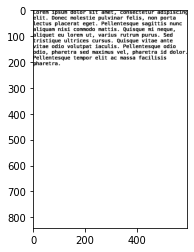

In [75]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

sample_a4_page = rgb2gray(mpimg.imread("sample_text.png"))

height = 20
width = 12

M = sample_a4_page.shape[0] # wierszy
N = sample_a4_page.shape[1] # kolumn

m_offset = 0   # pixel offset from start
n_offset = 0   # pixel offset from start
new_line_offset = 2

letters = []
M=int(M/4)
for mi in range((M - m_offset - height)//(height+new_line_offset)):
    for ni in range((N - n_offset - width)//width):
        
        # define boundaries 
        m_start = mi*(height+new_line_offset)        +m_offset
        m_stop  = mi*(height+new_line_offset)+height +m_offset
        n_start = ni*width                           +n_offset
        n_stop  = ni*width+width                     +n_offset 
        
        # slice a letter
        current_letter = sample_a4_page[m_start:m_stop, n_start:n_stop]
        letters.append(current_letter)

letters = np.array(letters)

print(f"letters shape: {letters.shape}")

print(f"mi = 0 : {(M - m_offset - height)//height}")
print(f"ni = 0 : {(N - n_offset - width)//width}")
   
plt.imshow(sample_a4_page, cmap=plt.get_cmap('gray'))
plt.show()  

### Verify split accuracy

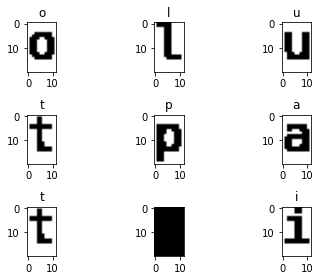

In [80]:
fig = plt.figure()
start = 300

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(letters[start+i], cmap=plt.get_cmap('gray'))
    plt.title(chr( model.predict(letters[start+i].reshape(1, height, width, 1)).argmax()))
fig.tight_layout(h_pad=1)
plt.show()

### Recognize text

In [81]:
from textwrap import wrap
from time import time
letters = np.array(letters)
tstart = time()
recognized_text = "".join([chr(model.predict(letter.reshape(1, height, width, 1)).argmax()) for letter in letters])
tstop = time()
print("\n".join(wrap(" ".join(recognized_text.split()), width=70)))
print(f"time passed: {(int)(tstop-tstart)//3600}h {(int)(tstop-tstart)%3600//60}m {(int)(tstop-tstart)%60}s")

Lorem ipsum dolor sit amet, consectetur adipiscielit. Donec molestie
pulvinar felis, non porta lectus placerat eget. Pellentesque sagittis
nuncaliquam nisi commodo mattis. Quisque mi neque, aliquet eu lorem
ut, varius rutrum purus. Sed tristique ultrices cursus. Quisque vitae
ante vitae odio volutpat iaculis. Pellentesque odio odio, pharetra sed
maximus vel, pharetra id dolo
time passed: 0h 0m 26s


## ------ OTHER ------

## Regularization

This regularization is popularly known as weight decay as it forces the weights to decay towards zero (but not exactly zero). This strategy drives the weights closer to the origin by adding the regularization term omega which is defined as:
$$
cost = loss + \frac{\lambda}{2m} \sum ||\omega||^2
$$

In [64]:
# from tensorflow.keras import regularizers
# model = Sequential()
# model.add(Conv2D(32, (3,3), activation = 'relu',input_shape=(height, width, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3,3), activation = 'relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3,3), activation = 'relu'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(Dense(10,activation='softmax', kernel_regularizer=regularizers.l2(0.0001)))
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(x_train,train_labels, epochs=5)
# test_loss, test_acc = model.evaluate(x_test, test_labels)

## Dropout ???

Dropout is another interesting regularization technique. At every iteration, it randomly selects some nodes and removes them along with all of their incoming and outgoing connections so each iteration has a different set of nodes and this results in a different set of outputs.

In [65]:
# from keras.layers import Dropout
# model = Sequential()
# model.add(Conv2D(32, (3,3), activation = 'relu',input_shape=(height, width, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3,3), activation = 'relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3,3), activation = 'relu'))
# model.add(Flatten())
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(Dense(10,activation='softmax', kernel_regularizer=regularizers.l2(0.0001)))
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(x_train,train_labels, epochs=5)
# test_loss, test_acc = model.evaluate(x_test, test_labels)

## Data augmentation

The simplest way to reduce overfitting is to increase the size of the training data. In this case, there are a few ways of increasing the size of the training data –rotating the image, flipping, scaling, shifting, etc.

In [66]:
# from keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rotation_range=40,
#                             width_shift_range=0.2,
#                             height_shift_range=0.2,
#                             shear_range=0.2,
#                             zoom_range=0.2,
#                             horizontal_flip=True,
#                             fill_mode='nearest')
# train_datagen.fit(x_train)

# model = Sequential()
# model.add(Conv2D(32, (3,3), activation = 'relu',input_shape=(height, width, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3,3), activation = 'relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3,3), activation = 'relu'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(10,activation='softmax'))
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(x_train,train_labels, epochs=5)
# test_loss, test_acc = model.evaluate(x_test, test_labels)

## Early stopping

Early stopping is a type of cross-validation strategy where we keep one part of the training set as the validation set. When we see that the performance on the validation set is getting worse, we immediately stop the training on the model.

In [67]:
# from keras.callbacks import EarlyStopping
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(x_train,train_labels, epochs=5, validation_data =(x_test, test_labels),
# callbacks = [EarlyStopping(monitor = 'val_accuracy', patience = 2)])